# Tracking Covid19 statistics in South Africa

## Data source

Using Covid19 data from John Hopkins University:  
https://github.com/CSSEGISandData/COVID-19  
https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6  
https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series  

World population data taken from  
https://data.worldbank.org/indicator/sp.pop.totl


## Other Trackers

Much nicer than this one...

South Africa  
https://datastudio.google.com/reporting/15817068-62f2-4101-8e0f-385e2ddd9326/page/wI9JB  
http://cip.csag.uct.ac.za/monitoring/corona/

International  
https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6  
https://www.covidvisualizer.com/  
https://www.worldometers.info/coronavirus/  

## Analysis

The results are at the end of the notebook

In [1]:
import pandas as pd
import numpy as np
import urllib.request as request
import matplotlib.pyplot as plt
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import matplotlib.dates as mdates
from datetime import datetime


Read the data as currently stored on GitHub in the JHU repository

In [2]:
ghFolder = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series'
ghFiles = [
    ['Confirmed','time_series_covid19_confirmed_global.csv'],
    ['Deaths','time_series_covid19_deaths_global.csv'],
    ['Recovered','time_series_covid19_recovered_global.csv'],
    ]

In [3]:
dfg={}
for lst  in ghFiles:
    # read data from github
    dfg[lst[0]] = pd.read_csv('/'.join([ghFolder,lst[1]]))

Get the world statistics

In [4]:
dfw = {}
for i,key in enumerate(dfg.keys()):
    df = dfg[key]
    dfsum = df.sum(axis = 0, skipna = True) 
    dfsum = dfsum.drop(['Country/Region','Lat','Long']).to_frame()
    dfsum.columns = ['Count']
    # find all dates with zero incidence
    indexNames = dfsum[dfsum['Count'] == 0].index
     # Delete these row indexes from dataFrame
    dfsum = dfsum.drop(indexNames)

    # get dates from string
    dfsum.reset_index(level=0, inplace=True)
    dfsum['Date'] = pd.to_datetime(dfsum['index'] ,dayfirst=True, format='%m/%d/%y')
     # Delete these row index column from dataFrame
    dfsum = dfsum.drop('index',axis=1)
    dfw[key] = dfsum

# print(dfw)

Get South Africa statistics

In [5]:
dfs = {}
for i,key in enumerate(dfg.keys()):
    df = dfg[key]
    dfT = df[df['Country/Region']=='South Africa'].T
    dfT = dfT.drop(['Province/State', 'Country/Region','Lat','Long'])
    dfT.columns=['Count']
    
    # find all dates with zero incidence
    indexNames = dfT[dfT['Count'] == 0].index
     # Delete these row indexes from dataFrame
    dfT = dfT.drop(indexNames)

    # get dates from string
    dfT.reset_index(level=0, inplace=True)
    dfT['Date'] = pd.to_datetime(dfT['index'] ,dayfirst=True, format='%m/%d/%y')
    
    dfs[key] = dfT

# print(dfs)

# Plot ZA data

The graphs below show the South African statistics along rows as (1) cases confirmed, (2) deaths, and (3) recovered.  The columns show (1) linear y-scale [shows magnitude better], (2) logarithmic y-scale [for comparison with most other graphs], (3) the daily changes, and (4) how South Africa compares with other countries in the world [see below].

The comparison of South Africa with the rest of the world is a gross simplification using the current snapshot. It is calculated as the cases in South Africa divided by ZA population, all this divided by cases in the world divided by world population.  This graph does not take into account day-zero (D0) which is the first occurrence in each of the countries.  

A more accurate relative performance calculation would be to take into account D0 of all the countries.
This can by done by counting the days since D0 for each country and calculating the ratio using the days since D0 as time scale.  This is not yet done below, will be done some time.

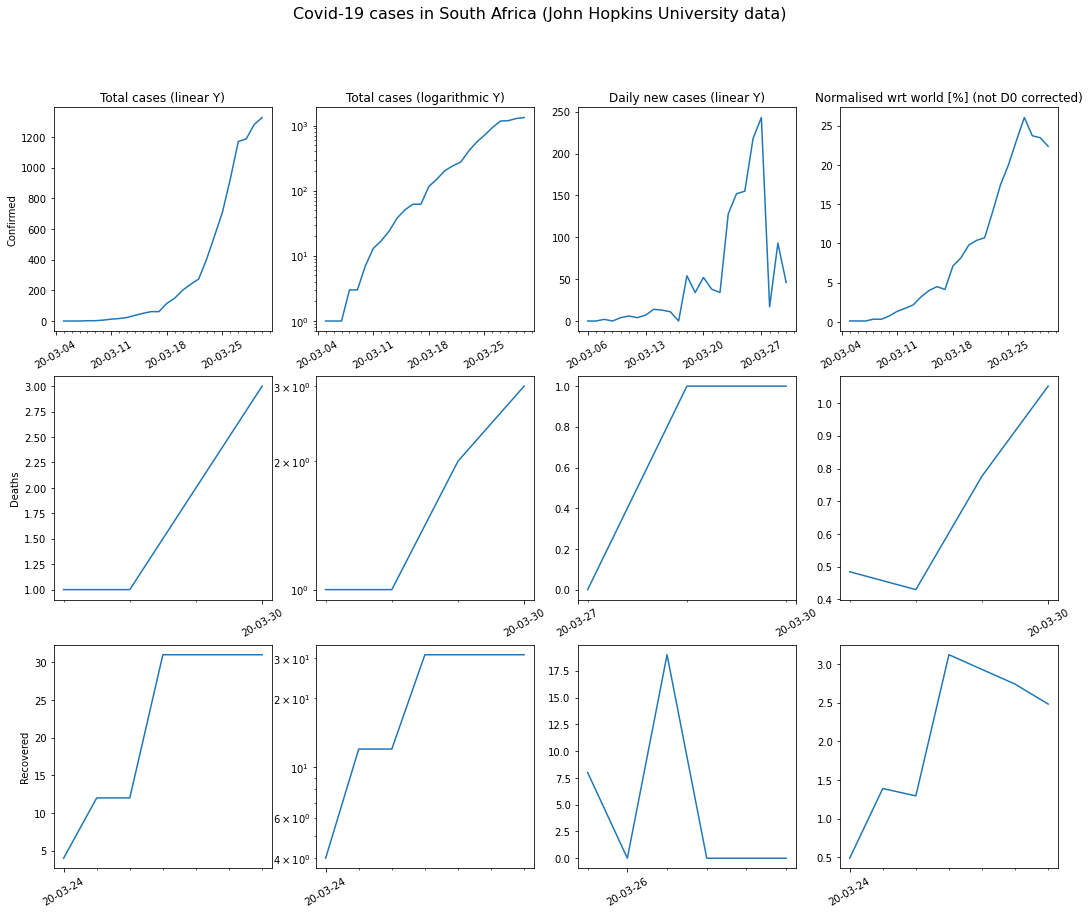

In [6]:
fig, axs = plt.subplots(3,4,figsize=(18,14))
ptypes = ['Total cases (linear Y)','Total cases (logarithmic Y)','Daily new cases (linear Y)','Normalised wrt world [%] (not D0 corrected)']
# formatter = DateFormatter('%m/%d/%y')

peopleWorld = 7.53e9
peopleZA = 56.72e6

for i,key in enumerate(dfs.keys()):
    dfS = dfs[key]
    dfW = dfw[key]
    dfS = dfS.join(dfW.set_index('Date'), on='Date',rsuffix='_W')
    
    # plot the data
    fig.suptitle('Covid-19 cases in South Africa (John Hopkins University data)', fontsize=16)
    axs[i, 0].plot(dfS['Date'],dfS['Count'])
    axs[i, 1].semilogy(dfS['Date'],dfS['Count'])
    axs[i, 2].plot(dfS['Date'][1:],np.diff(dfS['Count']))
    axs[i, 3].plot(dfS['Date'],100*(dfS['Count']/peopleZA)/((dfS['Count_W']-dfS['Count'])/(peopleWorld-peopleZA)))

    for j in [0,1,2,3]:
        axs[i,j].xaxis.set_tick_params(rotation=30, labelsize=10)
        # format the ticks
        axs[i,j].xaxis.set_major_locator(mdates.DayLocator(interval=7))
        axs[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
        axs[i,j].xaxis.set_minor_locator(mdates.DayLocator())
        if i==0:
            axs[i,j].set_title(ptypes[j])
        if j==0:
            axs[i,0].set_ylabel(key)


In [7]:
# to get software versions
# https://github.com/rasbt/watermark
# An IPython magic extension for printing date and time stamps, version numbers, and hardware information. 
# you only need to do this once
# !pip install watermark

%load_ext watermark
%watermark -v -m -p numpy,pandas -g 

CPython 3.7.3
IPython 7.13.0

numpy 1.18.1
pandas 1.0.3

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
Git hash   : 361e06a96538abe15c7b508891107663746faad8
